# NLP Classification of Articles

### Import Necessary Packages

In [1]:
import pandas as pd
import numpy as np

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#for word embedding
import gensim
from gensim.models import Word2Vec

## Load dataset

In [ ]:
data_train = pd.read_csv('data_train.txt', header=None)
data_train.columns = ['text']
data_test = pd.read_csv('data_valid.txt', header=None)
data_test.columns = ['text']
labels_train = pd.read_csv('labels_train_original.txt', header=None)
labels_train.columns = ["label"]
labels_test = pd.read_csv('labels_valid_original.txt', header=None)
labels_test.columns = ["label"]

In [ ]:
data_train

,text
0,the sign in front of the steepled church read ...
1,lindsey larsen a soprano and samuel ramey the ...
2,to the editor sylvia ann hewlett 's book creat...
3,illinois tool works inc glenview ill a maker o...
4,to the editor robert schaeffer op ed feb 19 ex...
...,...
1995,to the editor re invective 's comeback by will...
1996,a critic 's notebook article on aug 2 about th...
1997,mike shanahan the winning coach in super bowls...
1998,dear diary at a recent performance of the full...


In [ ]:
df_train = pd.DataFrame()
df_train['text'] = data_train
df_train['orig_label'] = labels_train
df_train

,text,orig_label
0,the sign in front of the steepled church read ...,News
1,lindsey larsen a soprano and samuel ramey the ...,Classifieds
2,to the editor sylvia ann hewlett 's book creat...,Opinion
3,illinois tool works inc glenview ill a maker o...,News
4,to the editor robert schaeffer op ed feb 19 ex...,Opinion
...,...,...
1995,to the editor re invective 's comeback by will...,Opinion
1996,a critic 's notebook article on aug 2 about th...,Features
1997,mike shanahan the winning coach in super bowls...,News
1998,dear diary at a recent performance of the full...,Classifieds


In [ ]:
df_test = pd.DataFrame()
df_test['text'] = data_test
df_test['orig_label'] = labels_test
df_test

,text,orig_label
0,to the editor re restructuring for security by...,Opinion
1,to the editor in small town gay america op ed ...,Opinion
2,don king the boxing promoter has stated that m...,Opinion
3,to the editor bill keller god and george w bus...,Opinion
4,andres rios stood in front of il monello and r...,News
...,...,...
1995,there are plenty of lines in shakespeare 's wo...,Features
1996,to the editor sadly we appear as hypocrites to...,Opinion
1997,the baseball fates played a cruel joke on the ...,News
1998,under pressure from congress to explain lapses...,Classifieds


In [ ]:
# Converting labels to numeric
def label_conv(dataset):
    dataset['target'] = None
    for i in range(len(dataset)):
        if dataset['orig_label'][i] == "News":
            dataset['target'][i] = 0
        elif dataset['orig_label'][i] == "Opinion":
            dataset['target'][i]  = 1
        elif dataset['orig_label'][i] == "Classifieds":
            dataset['target'][i] = 2
        elif dataset['orig_label'][i] == "Features":
            dataset['target'][i] = 3

label_conv(df_train)
label_conv(df_test)

In [ ]:
# Number of observations for each class in training dataset
print(df_train['target'].value_counts())

2    523
0    504
3    488
1    485
Name: target, dtype: int64


<AxesSubplot:title={'center':'Pie chart of Sentiment Class'}, ylabel='Class'>

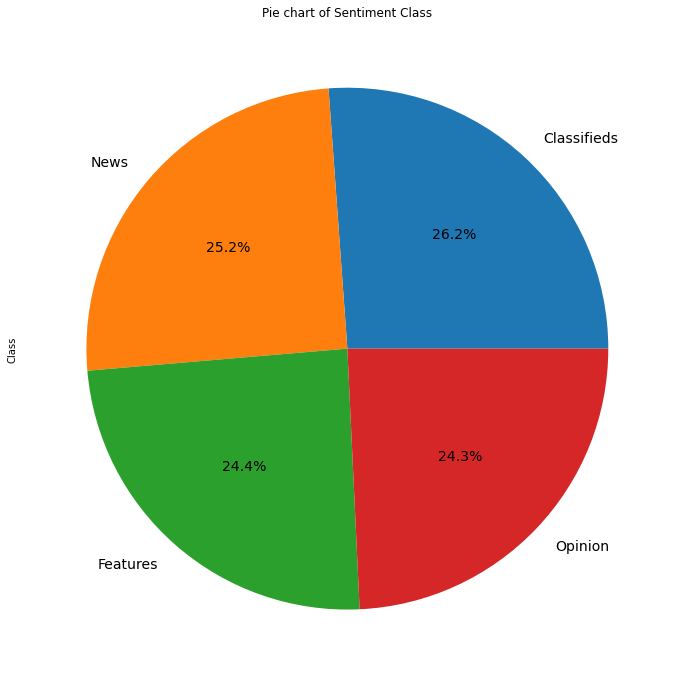

In [ ]:
df2=df_train.copy(deep=True)
df2["Class"] = df2['orig_label']
pie1=pd.DataFrame(df2['Class'].replace(0,'News').replace(1,'Opinion').replace(2,'Classifieds').replace(3,'Features').value_counts())
pie1.reset_index(inplace=True)
pie1.plot(kind='pie', title='Pie chart of Sentiment Class',y = 'Class', 
          autopct='%1.1f%%', shadow=False, labels=pie1['index'], legend = False, fontsize=14, figsize=(12,12))

## Pre-process Text

In [ ]:
#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text

 
# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [ ]:
# Final pre-processing
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

df_train['clean_text'] = df_train['text'].apply(lambda x: finalpreprocess(x))
df_train.head()

,text,orig_label,target,clean_text
0,the sign in front of the steepled church read ...,News,0,sign front steepled church read sunday sermon ...
1,lindsey larsen a soprano and samuel ramey the ...,Classifieds,2,lindsey larsen soprano samuel ramey bass marry...
2,to the editor sylvia ann hewlett 's book creat...,Opinion,1,editor sylvia ann hewlett book create life ing...
3,illinois tool works inc glenview ill a maker o...,News,0,illinois tool work inc glenview ill maker ever...
4,to the editor robert schaeffer op ed feb 19 ex...,Opinion,1,editor robert schaeffer op ed feb explain dear...


## Vectorize the text

In [ ]:
#SPLITTING THE TRAINING DATASET INTO TRAIN AND TEST
X_train, X_test, y_train, y_test = train_test_split(df_train["clean_text"],df_train["target"],test_size=0.2,shuffle=True)
y_test = y_test.astype('int')
y_train = y_train.astype('int')

#Word2Vec
# Word2Vec runs on tokenized sentences
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  
X_test_tok= [nltk.word_tokenize(i) for i in X_test]

In [ ]:
#Tf-Idf
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

#building Word2Vec model
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))
    def fit(self, X, y):
        return self
    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X])
    
df_train['clean_text_tok']=[nltk.word_tokenize(i) for i in df_train['clean_text']]
model = Word2Vec(df_train['clean_text_tok'],min_count=1)     
w2v = dict(zip(model.wv.index_to_key, model.wv.vectors))
modelw = MeanEmbeddingVectorizer(w2v)

# converting text to numerical data using Word2Vec
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_test_vectors_w2v = modelw.transform(X_test_tok)

## Machine Learning Step

In [ ]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)
lr_tfidf = LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  

#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_test_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]

print(classification_report(y_test,y_predict))
print('Confusion Matrix:\n',confusion_matrix(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.66      0.63      0.65       100
           1       0.76      0.90      0.82        89
           2       0.68      0.66      0.67       108
           3       0.59      0.55      0.57       103

    accuracy                           0.68       400
   macro avg       0.68      0.68      0.68       400
weighted avg       0.67      0.68      0.67       400

Confusion Matrix:
 [[63  9 14 14]
 [ 4 80  3  2]
 [14  0 71 23]
 [14 16 16 57]]


In [ ]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression (W2v)
lr_w2v=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_w2v.fit(X_train_vectors_w2v, y_train)  #model

#Predict y value for test dataset
y_predict = lr_w2v.predict(X_test_vectors_w2v)
y_prob = lr_w2v.predict_proba(X_test_vectors_w2v)[:,1]

print(classification_report(y_test,y_predict))
print('Confusion Matrix:\n',confusion_matrix(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.62      0.54      0.58       100
           1       0.59      0.84      0.69        89
           2       0.49      0.45      0.47       108
           3       0.52      0.44      0.47       103

    accuracy                           0.56       400
   macro avg       0.56      0.57      0.55       400
weighted avg       0.55      0.56      0.55       400

Confusion Matrix:
 [[54 17 21  8]
 [ 5 75  4  5]
 [16 14 49 29]
 [12 21 25 45]]


In [ ]:
#FITTING THE CLASSIFICATION MODEL using Naive Bayes(tf-idf)
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, y_train)  

#Predict y value for test dataset
y_predict = nb_tfidf.predict(X_test_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]

print(classification_report(y_test,y_predict))
print('Confusion Matrix:\n',confusion_matrix(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.66      0.62      0.64       100
           1       0.71      0.85      0.78        89
           2       0.62      0.66      0.64       108
           3       0.61      0.50      0.55       103

    accuracy                           0.65       400
   macro avg       0.65      0.66      0.65       400
weighted avg       0.65      0.65      0.64       400

Confusion Matrix:
 [[62  9 19 10]
 [ 6 76  5  2]
 [13  3 71 21]
 [13 19 20 51]]


In [ ]:
#Pre-processing the new dataset
df_test['clean_text'] = df_test['text'].apply(lambda x: finalpreprocess(x)) #preprocess the data
X_test=df_test['clean_text']
y_test=df_test['target']
y_test = y_test.astype('int')

#converting words to numerical data using tf-idf
X_vector=tfidf_vectorizer.transform(X_test)

#use the best model to predict 'target' value for the new dataset 
y_predict = lr_tfidf.predict(X_vector)      
y_prob = lr_tfidf.predict_proba(X_vector)[:,1]
df_test['predict_prob']= y_prob
df_test['target']= y_predict
final=df_test[['clean_text','target']].reset_index(drop=True)
print(final.head())

                                          clean_text  target
0  editor restructure security warren rudman gary...       1
1  editor small town gay america op ed nov adam g...       1
2  king box promoter state recent presidential ex...       1
3  editor bill keller god george w bush column ma...       1
4  andres rios stand front il monello recite dish...       2


In [ ]:
print(classification_report(y_test,y_predict))
print('Confusion Matrix:\n',confusion_matrix(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.71      0.61      0.66       512
           1       0.75      0.87      0.80       507
           2       0.67      0.73      0.70       470
           3       0.63      0.57      0.60       511

    accuracy                           0.69      2000
   macro avg       0.69      0.69      0.69      2000
weighted avg       0.69      0.69      0.69      2000

Confusion Matrix:
 [[311  46  75  80]
 [ 18 439  22  28]
 [ 45  18 343  64]
 [ 61  85  72 293]]
